In [ ]:
#TP FINAL PROGRAMACION

In [45]:
# Celda 1: Imports y rutas de archivos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

# Carpeta base del TP
base_dir = r"C:\Users\gasto\Desktop\Taller de Programación\TP FINAL"

# Rutas de los archivos
gmd_path = base_dir + r"\GMD.xlsx"
mpft_path = base_dir + r"\MPFT FMI.csv"

print("Ruta GMD:", gmd_path)
print("Ruta MPFT:", mpft_path)

Ruta GMD: C:\Users\gasto\Desktop\Taller de Programación\TP FINAL\GMD.xlsx
Ruta MPFT: C:\Users\gasto\Desktop\Taller de Programación\TP FINAL\MPFT FMI.csv


In [46]:
# Celda 2: Cargar GMD (sheet 'data_final') y explorar

gmd = pd.read_excel(gmd_path, sheet_name="data_final")

print("Dimensiones GMD:", gmd.shape)
print("\nPrimeras filas:")
display(gmd.head())

print("\nColumnas disponibles en GMD:")
for c in gmd.columns:
    print(c)

Dimensiones GMD: (57021, 71)

Primeras filas:


,countryname,ISO3,id,year,nGDP,nGDP_USD,rGDP,rGDP_pc,rGDP_USD,deflator,...,cbrate,M0,M1,M2,M3,M4,SovDebtCrisis,CurrencyCrisis,BankingCrisis,CA_USD
0,Aruba,ABW,1,1960,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,ABW,1,1961,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,ABW,1,1962,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,1,1963,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,1,1964,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columnas disponibles en GMD:
countryname
ISO3
id
year
nGDP
nGDP_USD
rGDP
rGDP_pc
rGDP_USD
deflator
cons
cons_GDP
cons_USD
inv
inv_GDP
inv_USD
finv
finv_GDP
finv_USD
exports
exports_GDP
exports_USD
imports
imports_GDP
imports_USD
CA
CA_GDP
USDfx
REER
govexp
gen_govexp
gen_govexp_GDP
cgovexp
cgovexp_GDP
govrev
gen_govrev
cgovrev
gen_govrev_GDP
cgovrev_GDP
govtax
gen_govtax
cgovtax
gen_govtax_GDP
cgovtax_GDP
govdef_GDP
gen_govdef_GDP
gen_govdef
cgovdef_GDP
cgovdef
govdebt_GDP
gen_govdebt_GDP
gen_govdebt
cgovdebt_GDP
cgovdebt
HPI
CPI
infl
pop
unemp
strate
ltrate
cbrate
M0
M1
M2
M3
M4
SovDebtCrisis
CurrencyCrisis
BankingCrisis
CA_USD


In [47]:
# Celda 3: Lista de países desarrollados (economías avanzadas)

advanced_iso3 = [
    "AUS","AUT","BEL","CAN","CHE","DEU","DNK","ESP","FIN","FRA",
    "GBR","GRC","IRL","ISL","ITA","JPN","KOR","LUX","NLD","NOR",
    "NZL","PRT","SWE","USA","CZE","ISR"
]

len(advanced_iso3), advanced_iso3

(26,
 ['AUS',
  'AUT',
  'BEL',
  'CAN',
  'CHE',
  'DEU',
  'DNK',
  'ESP',
  'FIN',
  'FRA',
  'GBR',
  'GRC',
  'IRL',
  'ISL',
  'ITA',
  'JPN',
  'KOR',
  'LUX',
  'NLD',
  'NOR',
  'NZL',
  'PRT',
  'SWE',
  'USA',
  'CZE',
  'ISR'])

In [48]:
# Celda 4: Filtrar GMD a economías avanzadas, year >= 2000, y seleccionar variables

# 1) Filtrar por ISO3 ∈ advanced_iso3
gmd_dev = gmd[gmd["ISO3"].isin(advanced_iso3)].copy()

# 2) Filtrar por años (desde 2000 en adelante)
gmd_dev = gmd_dev[gmd_dev["year"] >= 2000].copy()

print("Dimensiones GMD (desarrollados, year >= 2000):", gmd_dev.shape)
print("Rango de años:", gmd_dev["year"].min(), "-", gmd_dev["year"].max())
print("Países en la muestra (desarrollados):")
print(sorted(gmd_dev["countryname"].unique()))

# 3) Variables macro y de crisis que nos interesan (panel país-año)
vars_keep = [
    # Identificadores
    "countryname", "ISO3", "id", "year",
    
    # Dummies de crisis (NO promediarlas luego)
    "BankingCrisis", "CurrencyCrisis", "SovDebtCrisis",
    
    # Cuenta corriente
    "CA", "CA_GDP", "CA_USD",
    
    # Política monetaria y tasas
    "cbrate",         # Central Bank Policy Rate
    "strate",         # Short-term Interest Rate
    "ltrate",         # Long-term Interest Rate
    "USDfx", "REER",
    
    # Precios y actividad
    "CPI", "infl", "deflator", "nGDP", "rGDP", "rGDP_pc", "rGDP_USD",
    
    # Consumo e inversión
    "cons", "cons_GDP", "inv", "inv_GDP", "finv", "finv_GDP",
    
    # Comercio exterior
    "exports", "exports_GDP", "imports", "imports_GDP",
    
    # Gobierno central
    "cgovdebt", "cgovdebt_GDP", "cgovdef", "cgovdef_GDP",
    "cgovexp", "cgovexp_GDP", "cgovrev", "cgovrev_GDP",
    "cgovtax", "cgovtax_GDP",
    
    # Gobierno general
    "gen_govdebt", "gen_govdebt_GDP",
    "gen_govdef", "gen_govdef_GDP",
    "gen_govexp", "gen_govexp_GDP",
    "gen_govrev", "gen_govrev_GDP",
    "gen_govtax", "gen_govtax_GDP",
    
    # Gobierno consolidado
    "govdebt_GDP", "govdef_GDP", "govexp", "govrev", "govtax",
    
    # Agregados monetarios (no promediarlos)
    "M0", "M1", "M2", "M3", "M4",
    
    # Otros
    "HPI", "pop", "unemp"
]

vars_keep_exist = [c for c in vars_keep if c in gmd_dev.columns]

print("\nCantidad de variables seleccionadas que existen:", len(vars_keep_exist))
print("Variables seleccionadas:")
print(vars_keep_exist)

gmd_dev_subset = gmd_dev[vars_keep_exist].copy()

print("\nDimensiones GMD desarrollados (panel, subset):", gmd_dev_subset.shape)
display(gmd_dev_subset.head())

Dimensiones GMD (desarrollados, year >= 2000): (806, 71)
Rango de años: 2000 - 2030
Países en la muestra (desarrollados):
['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

Cantidad de variables seleccionadas que existen: 65
Variables seleccionadas:
['countryname', 'ISO3', 'id', 'year', 'BankingCrisis', 'CurrencyCrisis', 'SovDebtCrisis', 'CA', 'CA_GDP', 'CA_USD', 'cbrate', 'strate', 'ltrate', 'USDfx', 'REER', 'CPI', 'infl', 'deflator', 'nGDP', 'rGDP', 'rGDP_pc', 'rGDP_USD', 'cons', 'cons_GDP', 'inv', 'inv_GDP', 'finv', 'finv_GDP', 'exports', 'exports_GDP', 'imports', 'imports_GDP', 'cgovdebt', 'cgovdebt_GDP', 'cgovdef', 'cgovdef_GDP', 'cgovexp', 'cgovexp_GDP', 'cgovrev', 'cgovrev_GDP', 'cgovtax', 'cgovtax_GDP', 'gen_govdebt

,countryname,ISO3,id,year,BankingCrisis,CurrencyCrisis,SovDebtCrisis,CA,CA_GDP,CA_USD,...,govrev,govtax,M0,M1,M2,M3,M4,HPI,pop,unemp
2438,Australia,AUS,13,2000,0.0,0.0,0.0,-27667.001953,-4.023150,-15487.273438,...,247720.96875,196373.437500,31189.0,137600.0,447000.0,441100.0,NaN,42.490101,19.028799,6.292
2439,Australia,AUS,13,2001,0.0,0.0,0.0,-16666.000000,-2.280256,-7986.938477,...,255031.00000,214922.234375,37016.0,166900.0,507000.0,502200.0,NaN,49.091301,19.274700,6.775
2440,Australia,AUS,13,2002,0.0,1.0,0.0,-30002.000000,-3.831893,-16002.234375,...,281947.53125,218189.515625,37512.0,214500.0,535000.0,536500.0,NaN,58.289200,19.495199,6.358
2441,Australia,AUS,13,2003,0.0,0.0,0.0,-44508.000000,-5.357407,-29307.732422,...,300318.09375,238618.671875,38844.0,236100.0,606000.0,600900.0,NaN,69.311401,19.720699,5.942
2442,Australia,AUS,13,2004,0.0,0.0,0.0,-56599.996094,-6.322595,-41286.949219,...,319269.62500,257724.703125,40108.0,252100.0,677000.0,655400.0,NaN,69.506302,19.932699,5.383


In [49]:
# Celda 5: Guardar base GMD desarrollados (panel país-año)

out_gmd_csv = base_dir + r"\gmd_desarrollados_panel.csv"
gmd_dev_subset.to_csv(out_gmd_csv, index=False)

print("Base GMD desarrollados (panel) guardada en:")
print(out_gmd_csv)

Base GMD desarrollados (panel) guardada en:
C:\Users\gasto\Desktop\Taller de Programación\TP FINAL\gmd_desarrollados_panel.csv


In [50]:
# Celda 6: Cargar MPFT FMI, renombrar COUNTRY, crear año y agregar ISO3 desde GMD

mpft = pd.read_csv(mpft_path)

print("Dimensiones MPFT:", mpft.shape)
print("\nPrimeras filas MPFT:")
display(mpft.head())

print("\nColumnas originales en MPFT:")
print(list(mpft.columns))

# 1) Renombrar COUNTRY -> countryname
if "COUNTRY" in mpft.columns:
    mpft = mpft.rename(columns={"COUNTRY": "countryname"})
    print("\nRenombré 'COUNTRY' a 'countryname'.")
else:
    print("\nATENCIÓN: no encontré columna 'COUNTRY' en MPFT, revisar CSV.")

# 2) Ajustar nombre de Corea para matchear con GMD
mpft["countryname"] = mpft["countryname"].replace({
    "Korea, Republic of": "South Korea"
})

# 3) Crear variable año (TIME_PERIOD)
if "TIME_PERIOD" in mpft.columns:
    mpft["year"] = mpft["TIME_PERIOD"].astype(int)
else:
    raise ValueError("No se encontró la columna TIME_PERIOD en MPFT FMI.csv")

print("\nEjemplo de nombres de país en MPFT luego de ajuste:")
print(sorted(mpft["countryname"].unique())[:20])

# 4) Mapa país-ISO3 desde la GMD completa
iso_map = gmd[["countryname", "ISO3"]].drop_duplicates()
print("\nMapa país-ISO3 (primeras filas):")
display(iso_map.head())

# 5) Merge para traer ISO3 a MPFT
mpft = mpft.merge(iso_map, on="countryname", how="left")

print("\nDimensiones MPFT después de agregar ISO3:", mpft.shape)
print("Columnas finales en MPFT:")
print(list(mpft.columns))

print("\nCantidad de filas con ISO3 no nulo en MPFT:", mpft["ISO3"].notna().sum())
display(mpft[mpft["ISO3"].notna()].head())

Dimensiones MPFT: (14176, 40)

Primeras filas MPFT:


,COUNTRY,INDICATOR,TYPE_OF_TRANSFORMATION,FREQUENCY,TIME_PERIOD,OBS_VALUE,SCALE,PRECISION,DECIMALS_DISPLAYED,TRANSFORMATION,...,ACCESS_SHARING_LEVEL,ACCESS_SHARING_NOTES,SECURITY_CLASSIFICATION,SOURCE,SHORT_SOURCE_CITATION,FULL_SOURCE_CITATION,LICENSE,SUGGESTED_CITATION,KEY_INDICATOR,SERIES_NAME
0,Kenya,Monetary Policy Report (C),Index,Annual,2007,100.000000,Units,NaN,NaN,NaN,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN
1,Kenya,Monetary Policy Report (C),Index,Annual,2008,100.000000,Units,NaN,NaN,NaN,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN
2,Kenya,Monetary Policy Report (C),Index,Annual,2009,100.000000,Units,NaN,NaN,NaN,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN
3,Kenya,Monetary Policy Report (C),Index,Annual,2010,173.782022,Units,NaN,NaN,NaN,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN
4,Kenya,Monetary Policy Report (C),Index,Annual,2011,173.782022,Units,NaN,NaN,NaN,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN



Columnas originales en MPFT:
['COUNTRY', 'INDICATOR', 'TYPE_OF_TRANSFORMATION', 'FREQUENCY', 'TIME_PERIOD', 'OBS_VALUE', 'SCALE', 'PRECISION', 'DECIMALS_DISPLAYED', 'TRANSFORMATION', 'UNIT', 'DERIVATION_TYPE', 'OVERLAP', 'IMF_REGION', 'INCOME_GROUP', 'DOI', 'FULL_DESCRIPTION', 'AUTHOR', 'PUBLISHER', 'DEPARTMENT', 'CONTACT_POINT', 'TOPIC', 'TOPIC_DATASET', 'KEYWORDS', 'KEYWORDS_DATASET', 'LANGUAGE', 'PUBLICATION_DATE', 'UPDATE_DATE', 'METHODOLOGY', 'METHODOLOGY_NOTES', 'ACCESS_SHARING_LEVEL', 'ACCESS_SHARING_NOTES', 'SECURITY_CLASSIFICATION', 'SOURCE', 'SHORT_SOURCE_CITATION', 'FULL_SOURCE_CITATION', 'LICENSE', 'SUGGESTED_CITATION', 'KEY_INDICATOR', 'SERIES_NAME']

Renombré 'COUNTRY' a 'countryname'.

Ejemplo de nombres de país en MPFT luego de ajuste:
['Advanced Economies', 'Argentina', 'Armenia, Republic of', 'Australia', 'Brazil', 'Canada', 'Chile', "China, People's Republic of", 'Colombia', 'Czech Republic', 'Emerging Market Economies', 'Euro Area (EA)', 'Georgia', 'Ghana', 'Hungar

,countryname,ISO3
0,Aruba,ABW
71,Afghanistan,AFG
302,Angola,AGO
533,Anguilla,AIA
601,Albania,ALB



Dimensiones MPFT después de agregar ISO3: (14176, 42)
Columnas finales en MPFT:
['countryname', 'INDICATOR', 'TYPE_OF_TRANSFORMATION', 'FREQUENCY', 'TIME_PERIOD', 'OBS_VALUE', 'SCALE', 'PRECISION', 'DECIMALS_DISPLAYED', 'TRANSFORMATION', 'UNIT', 'DERIVATION_TYPE', 'OVERLAP', 'IMF_REGION', 'INCOME_GROUP', 'DOI', 'FULL_DESCRIPTION', 'AUTHOR', 'PUBLISHER', 'DEPARTMENT', 'CONTACT_POINT', 'TOPIC', 'TOPIC_DATASET', 'KEYWORDS', 'KEYWORDS_DATASET', 'LANGUAGE', 'PUBLICATION_DATE', 'UPDATE_DATE', 'METHODOLOGY', 'METHODOLOGY_NOTES', 'ACCESS_SHARING_LEVEL', 'ACCESS_SHARING_NOTES', 'SECURITY_CLASSIFICATION', 'SOURCE', 'SHORT_SOURCE_CITATION', 'FULL_SOURCE_CITATION', 'LICENSE', 'SUGGESTED_CITATION', 'KEY_INDICATOR', 'SERIES_NAME', 'year', 'ISO3']

Cantidad de filas con ISO3 no nulo en MPFT: 11096


,countryname,INDICATOR,TYPE_OF_TRANSFORMATION,FREQUENCY,TIME_PERIOD,OBS_VALUE,SCALE,PRECISION,DECIMALS_DISPLAYED,TRANSFORMATION,...,SECURITY_CLASSIFICATION,SOURCE,SHORT_SOURCE_CITATION,FULL_SOURCE_CITATION,LICENSE,SUGGESTED_CITATION,KEY_INDICATOR,SERIES_NAME,year,ISO3
0,Kenya,Monetary Policy Report (C),Index,Annual,2007,100.000000,Units,NaN,NaN,NaN,...,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN,2007,KEN
1,Kenya,Monetary Policy Report (C),Index,Annual,2008,100.000000,Units,NaN,NaN,NaN,...,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN,2008,KEN
2,Kenya,Monetary Policy Report (C),Index,Annual,2009,100.000000,Units,NaN,NaN,NaN,...,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN,2009,KEN
3,Kenya,Monetary Policy Report (C),Index,Annual,2010,173.782022,Units,NaN,NaN,NaN,...,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN,2010,KEN
4,Kenya,Monetary Policy Report (C),Index,Annual,2011,173.782022,Units,NaN,NaN,NaN,...,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN,2011,KEN


In [51]:
# Celda 7: Índices C / IA / PO / Overall por país-año (panel MPFT)

# Clasificar cada indicador en pilar C, PO o IA según 'INDICATOR'
mpft["pillar"] = None
mpft.loc[mpft["INDICATOR"].str.contains(r"\(C\)"),                 "pillar"] = "C"
mpft.loc[mpft["INDICATOR"].str.contains(r"\(PO\)|\(P0\)"),         "pillar"] = "PO"
mpft.loc[mpft["INDICATOR"].str.contains(r"\(IA\)"),                "pillar"] = "IA"

print("Conteo por pilar:")
print(mpft["pillar"].value_counts(dropna=False))

# Promedio dentro de cada pilar, por país-año
pillar_means = (
    mpft
    .dropna(subset=["pillar", "OBS_VALUE", "ISO3"])
    .groupby(["countryname", "ISO3", "year", "pillar"], as_index=False)["OBS_VALUE"]
    .mean()
)

print("\nPrimeras filas de promedios por país-año y pilar:")
display(pillar_means.head())

# Pivot a columnas: C, IA, PO
pillar_pivot = pillar_means.pivot(
    index=["countryname", "ISO3", "year"],
    columns="pillar",
    values="OBS_VALUE"
).reset_index()
pillar_pivot.columns.name = None

print("\nÍndices C, IA, PO por país-año:")
display(pillar_pivot.head())

# Índice global Overall por país-año
overall_panel = (
    mpft
    .dropna(subset=["OBS_VALUE", "ISO3"])
    .groupby(["countryname", "ISO3", "year"], as_index=False)["OBS_VALUE"]
    .mean()
    .rename(columns={"OBS_VALUE": "overall_index"})
)

# Unir pilares + overall
mpft_indices_panel = pillar_pivot.merge(
    overall_panel,
    on=["countryname", "ISO3", "year"],
    how="left"
)

# Filtrar economías avanzadas
mpft_adv_indices = mpft_indices_panel[
    mpft_indices_panel["ISO3"].isin(advanced_iso3)
].copy()

# Renombrar columnas
mpft_sub = mpft_adv_indices.rename(columns={
    "C": "C_index",
    "IA": "IA_index",
    "PO": "PO_index"
})

print("\nMPFT - índices IAPOC para economías avanzadas (panel país-año):")
print("Dimensiones:", mpft_sub.shape)
print("Rango de años:", mpft_sub["year"].min(), "-", mpft_sub["year"].max())
print("Países avanzados en MPFT:")
print(sorted(mpft_sub["countryname"].unique()))
display(mpft_sub.head())

Conteo por pilar:
pillar
C       4464
IA      4464
PO      4464
None     784
Name: count, dtype: int64

Primeras filas de promedios por país-año y pilar:


,countryname,ISO3,year,pillar,OBS_VALUE
0,Argentina,ARG,2007,C,100.0
1,Argentina,ARG,2007,IA,100.0
2,Argentina,ARG,2007,PO,100.0
3,Argentina,ARG,2008,C,100.0
4,Argentina,ARG,2008,IA,100.0



Índices C, IA, PO por país-año:


,countryname,ISO3,year,C,IA,PO
0,Argentina,ARG,2007,100.0,100.0,100.000000
1,Argentina,ARG,2008,100.0,100.0,100.000000
2,Argentina,ARG,2009,100.0,100.0,100.000000
3,Argentina,ARG,2010,50.0,50.0,40.857955
4,Argentina,ARG,2011,100.0,100.0,90.857955



MPFT - índices IAPOC para economías avanzadas (panel país-año):
Dimensiones: (144, 7)
Rango de años: 2007 - 2018
Países avanzados en MPFT:
['Australia', 'Canada', 'Czech Republic', 'Iceland', 'Israel', 'Japan', 'New Zealand', 'Norway', 'South Korea', 'Sweden', 'United Kingdom', 'United States']


,countryname,ISO3,year,C_index,IA_index,PO_index,overall_index
12,Australia,AUS,2007,100.000000,100.000000,100.0,100.000000
13,Australia,AUS,2008,100.000000,100.000000,100.0,100.000000
14,Australia,AUS,2009,100.000000,100.000000,100.0,100.000000
15,Australia,AUS,2010,55.601204,50.499058,50.0,52.073537
16,Australia,AUS,2011,105.601204,100.499058,100.0,102.073537


In [52]:
# Celda 7: Índices C / IA / PO / Overall por país-año (panel MPFT)

# Clasificar cada indicador en pilar C, PO o IA según 'INDICATOR'
mpft["pillar"] = None
mpft.loc[mpft["INDICATOR"].str.contains(r"\(C\)"),                 "pillar"] = "C"
mpft.loc[mpft["INDICATOR"].str.contains(r"\(PO\)|\(P0\)"),         "pillar"] = "PO"
mpft.loc[mpft["INDICATOR"].str.contains(r"\(IA\)"),                "pillar"] = "IA"

print("Conteo por pilar:")
print(mpft["pillar"].value_counts(dropna=False))

# Promedio dentro de cada pilar, por país-año
pillar_means = (
    mpft
    .dropna(subset=["pillar", "OBS_VALUE", "ISO3"])
    .groupby(["countryname", "ISO3", "year", "pillar"], as_index=False)["OBS_VALUE"]
    .mean()
)

print("\nPrimeras filas de promedios por país-año y pilar:")
display(pillar_means.head())

# Pivot a columnas: C, IA, PO
pillar_pivot = pillar_means.pivot(
    index=["countryname", "ISO3", "year"],
    columns="pillar",
    values="OBS_VALUE"
).reset_index()
pillar_pivot.columns.name = None

print("\nÍndices C, IA, PO por país-año:")
display(pillar_pivot.head())

# Índice global Overall por país-año
overall_panel = (
    mpft
    .dropna(subset=["OBS_VALUE", "ISO3"])
    .groupby(["countryname", "ISO3", "year"], as_index=False)["OBS_VALUE"]
    .mean()
    .rename(columns={"OBS_VALUE": "overall_index"})
)

# Unir pilares + overall
mpft_indices_panel = pillar_pivot.merge(
    overall_panel,
    on=["countryname", "ISO3", "year"],
    how="left"
)

# Filtrar economías avanzadas
mpft_adv_indices = mpft_indices_panel[
    mpft_indices_panel["ISO3"].isin(advanced_iso3)
].copy()

# Renombrar columnas
mpft_sub = mpft_adv_indices.rename(columns={
    "C": "C_index",
    "IA": "IA_index",
    "PO": "PO_index"
})

print("\nMPFT - índices IAPOC para economías avanzadas (panel país-año):")
print("Dimensiones:", mpft_sub.shape)
print("Rango de años:", mpft_sub["year"].min(), "-", mpft_sub["year"].max())
print("Países avanzados en MPFT:")
print(sorted(mpft_sub["countryname"].unique()))
display(mpft_sub.head())

Conteo por pilar:
pillar
C       4464
IA      4464
PO      4464
None     784
Name: count, dtype: int64

Primeras filas de promedios por país-año y pilar:


,countryname,ISO3,year,pillar,OBS_VALUE
0,Argentina,ARG,2007,C,100.0
1,Argentina,ARG,2007,IA,100.0
2,Argentina,ARG,2007,PO,100.0
3,Argentina,ARG,2008,C,100.0
4,Argentina,ARG,2008,IA,100.0



Índices C, IA, PO por país-año:


,countryname,ISO3,year,C,IA,PO
0,Argentina,ARG,2007,100.0,100.0,100.000000
1,Argentina,ARG,2008,100.0,100.0,100.000000
2,Argentina,ARG,2009,100.0,100.0,100.000000
3,Argentina,ARG,2010,50.0,50.0,40.857955
4,Argentina,ARG,2011,100.0,100.0,90.857955



MPFT - índices IAPOC para economías avanzadas (panel país-año):
Dimensiones: (144, 7)
Rango de años: 2007 - 2018
Países avanzados en MPFT:
['Australia', 'Canada', 'Czech Republic', 'Iceland', 'Israel', 'Japan', 'New Zealand', 'Norway', 'South Korea', 'Sweden', 'United Kingdom', 'United States']


,countryname,ISO3,year,C_index,IA_index,PO_index,overall_index
12,Australia,AUS,2007,100.000000,100.000000,100.0,100.000000
13,Australia,AUS,2008,100.000000,100.000000,100.0,100.000000
14,Australia,AUS,2009,100.000000,100.000000,100.0,100.000000
15,Australia,AUS,2010,55.601204,50.499058,50.0,52.073537
16,Australia,AUS,2011,105.601204,100.499058,100.0,102.073537


In [53]:
# Celda 8: Merge GMD (macro) + MPFT (índices IAPOC) país-año

# Cargar GMD panel limpio
gmd_panel = pd.read_csv(base_dir + r"\gmd_desarrollados_panel.csv")

print("Dimensiones GMD panel:", gmd_panel.shape)
print("Rango de años GMD:", gmd_panel["year"].min(), "-", gmd_panel["year"].max())

# Merge por ISO3, countryname y year
base_panel = gmd_panel.merge(
    mpft_sub,
    on=["ISO3", "countryname", "year"],
    how="inner"
)

print("\nDimensiones base_panel (GMD + MPFT):", base_panel.shape)
print("Rango de años en base_panel:", base_panel["year"].min(), "-", base_panel["year"].max())
print("Países en base_panel:")
print(sorted(base_panel["countryname"].unique()))

display(base_panel.head())

# Guardar base integrada
out_panel_csv = base_dir + r"\base_panel_gmd_mpft.csv"
base_panel.to_csv(out_panel_csv, index=False)
print("\nBase integrada guardada en:")
print(out_panel_csv)

Dimensiones GMD panel: (806, 65)
Rango de años GMD: 2000 - 2030

Dimensiones base_panel (GMD + MPFT): (144, 69)
Rango de años en base_panel: 2007 - 2018
Países en base_panel:
['Australia', 'Canada', 'Czech Republic', 'Iceland', 'Israel', 'Japan', 'New Zealand', 'Norway', 'South Korea', 'Sweden', 'United Kingdom', 'United States']


,countryname,ISO3,id,year,BankingCrisis,CurrencyCrisis,SovDebtCrisis,CA,CA_GDP,CA_USD,...,M2,M3,M4,HPI,pop,unemp,C_index,IA_index,PO_index,overall_index
0,Australia,AUS,13,2007,0.0,0.0,0.0,-76824.0,-6.774812,-64681.628906,...,1091230.0,984000.0,NaN,87.512100,20.827600,4.375,100.000000,100.000000,100.0,100.000000
1,Australia,AUS,13,2008,0.0,0.0,0.0,-58828.0,-4.756880,-51560.062500,...,1246290.0,1143400.0,NaN,84.027100,21.249201,4.250,100.000000,100.000000,100.0,100.000000
2,Australia,AUS,13,2009,0.0,0.0,0.0,-58710.0,-4.645429,-48587.679688,...,1252240.0,1189400.0,NaN,96.030998,21.691700,5.575,100.000000,100.000000,100.0,100.000000
3,Australia,AUS,13,2010,0.0,0.0,0.0,-49864.0,-3.649490,-46011.757812,...,1369640.0,1312000.0,NaN,100.290398,22.031799,5.208,55.601204,50.499058,50.0,52.073537
4,Australia,AUS,13,2011,0.0,0.0,0.0,-44090.0,-3.001214,-45650.781250,...,NaN,1415100.0,NaN,96.224602,22.340000,5.083,105.601204,100.499058,100.0,102.073537



Base integrada guardada en:
C:\Users\gasto\Desktop\Taller de Programación\TP FINAL\base_panel_gmd_mpft.csv


Variables utilizadas en descriptivos:
['C_index', 'IA_index', 'PO_index', 'overall_index', 'infl', 'cbrate', 'strate', 'rGDP_pc', 'cgovdebt_GDP', 'cgovdef_GDP', 'unemp', 'M0', 'M1', 'M2', 'M3', 'M4']

Resumen descriptivo (panel país-año):


,count,mean,std,min,25%,50%,75%,max
C_index,144.0,9.033528e+01,2.367050e+01,4.523391e+01,6.307808e+01,1.000000e+02,1.059623e+02,1.312551e+02
IA_index,144.0,8.721962e+01,2.516420e+01,4.723614e+01,5.555695e+01,1.000000e+02,1.004991e+02,1.505305e+02
PO_index,144.0,8.718653e+01,2.455819e+01,3.975582e+01,5.949631e+01,1.000000e+02,1.000000e+02,1.388978e+02
overall_index,144.0,8.830982e+01,2.401622e+01,4.569316e+01,5.936056e+01,1.000000e+02,1.028049e+02,1.333537e+02
infl,144.0,2.038453e+00,1.832010e+00,-1.362820e+00,9.878256e-01,1.896084e+00,2.699807e+00,1.269440e+01
cbrate,144.0,1.965278e+00,2.470733e+00,-5.000000e-01,3.437500e-01,1.437500e+00,2.500000e+00,1.800000e+01
strate,144.0,2.261682e+00,2.735666e+00,-6.608334e-01,4.947117e-01,1.573750e+00,3.074137e+00,1.830660e+01
rGDP_pc,144.0,3.755938e+06,8.867280e+06,2.730964e+04,5.551070e+04,2.695027e+05,1.419801e+06,3.715510e+07
cgovdebt_GDP,144.0,5.634225e+01,4.348658e+01,6.077793e+00,3.018252e+01,4.042220e+01,7.327417e+01,1.984379e+02
cgovdef_GDP,136.0,-9.707082e-01,5.554398e+00,-1.252471e+01,-4.454512e+00,-1.548085e+00,9.555067e-01,1.960000e+01



Matriz de correlación:


,C_index,IA_index,PO_index,overall_index,infl,cbrate,strate,rGDP_pc,cgovdebt_GDP,cgovdef_GDP,unemp,M0,M1,M2,M3,M4
C_index,1.000000,0.920634,0.950867,0.974972,0.072594,0.098475,0.115237,0.052529,-0.007888,-0.037142,-0.055335,-0.050912,0.003583,0.036606,0.034615,-0.056074
IA_index,0.920634,1.000000,0.953316,0.978292,0.056614,0.110568,0.135770,0.006644,0.011774,-0.073612,0.001611,-0.065399,-0.022623,0.019884,-0.009507,-0.340673
PO_index,0.950867,0.953316,1.000000,0.987663,0.061613,0.115195,0.132892,0.026226,0.019425,-0.033971,-0.049631,-0.001482,0.019507,0.014870,0.029413,-0.376627
overall_index,0.974972,0.978292,0.987663,1.000000,0.063804,0.109753,0.130046,0.029384,0.008377,-0.049574,-0.035299,-0.040194,0.000340,0.025376,0.018881,-0.264642
infl,0.072594,0.056614,0.061613,0.063804,1.000000,0.658466,0.707567,0.080086,-0.197635,-0.069307,0.009503,-0.232059,-0.209450,-0.178876,-0.111772,-0.437587
cbrate,0.098475,0.110568,0.115195,0.109753,0.658466,1.000000,0.966608,0.146511,-0.272217,0.086544,-0.223936,-0.239730,-0.161019,-0.095908,-0.066253,-0.461272
strate,0.115237,0.135770,0.132892,0.130046,0.707567,0.966608,1.000000,0.157305,-0.281447,0.114983,-0.215946,-0.254200,-0.165164,-0.094628,-0.065060,-0.580808
rGDP_pc,0.052529,0.006644,0.026226,0.029384,0.080086,0.146511,0.157305,1.000000,-0.050485,0.205774,-0.389514,0.336264,0.684268,0.892716,0.916959,0.810878
cgovdebt_GDP,-0.007888,0.011774,0.019425,0.008377,-0.197635,-0.272217,-0.281447,-0.050485,1.000000,-0.478573,-0.035896,0.678440,0.551417,0.304538,0.207964,0.733235
cgovdef_GDP,-0.037142,-0.073612,-0.033971,-0.049574,-0.069307,0.086544,0.114983,0.205774,-0.478573,1.000000,-0.447622,-0.107910,-0.050743,0.007544,0.085996,0.677283


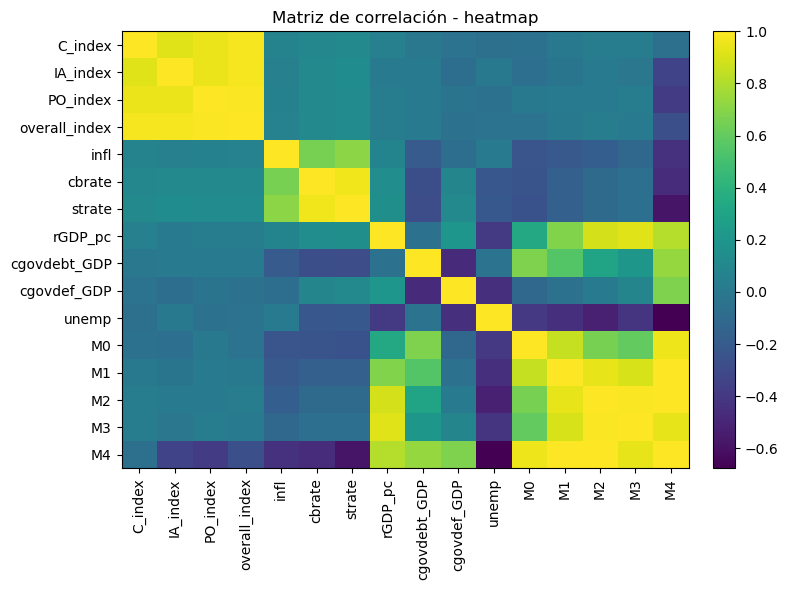

In [54]:
# Celda 9: Descriptivos básicos y correlación (panel país-año) + heatmap

vars_descriptivas = [
    # Índices de política monetaria
    "C_index", "IA_index", "PO_index", "overall_index",
    
    # Macro clave
    "infl",                    # Inflation Rate
    "cbrate",                  # Central Bank Policy Rate
    "strate",                  # Short-term Interest Rate
    "rGDP_pc",
    "cgovdebt_GDP",
    "cgovdef_GDP",
    "unemp",
    
    # Agregados monetarios
    "M0", "M1", "M2", "M3", "M4"
]

vars_descriptivas = [v for v in vars_descriptivas if v in base_panel.columns]

print("Variables utilizadas en descriptivos:")
print(vars_descriptivas)

print("\nResumen descriptivo (panel país-año):")
display(base_panel[vars_descriptivas].describe().T)

print("\nMatriz de correlación:")
corr_matrix = base_panel[vars_descriptivas].corr()
display(corr_matrix)

# Heatmap de la matriz de correlación
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_matrix, aspect="auto")
plt.xticks(range(len(vars_descriptivas)), vars_descriptivas, rotation=90)
plt.yticks(range(len(vars_descriptivas)), vars_descriptivas)
plt.title("Matriz de correlación - heatmap")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Distribución de índices de política monetaria:


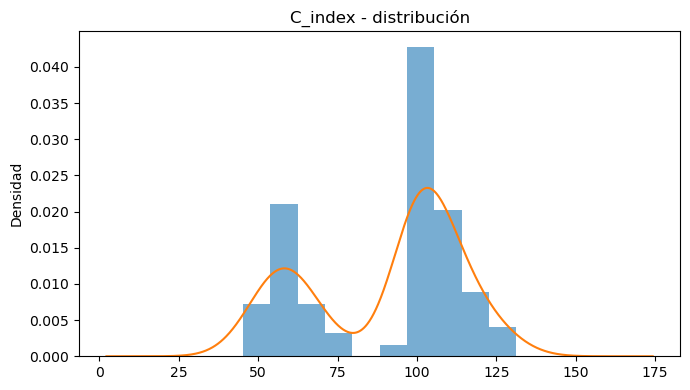

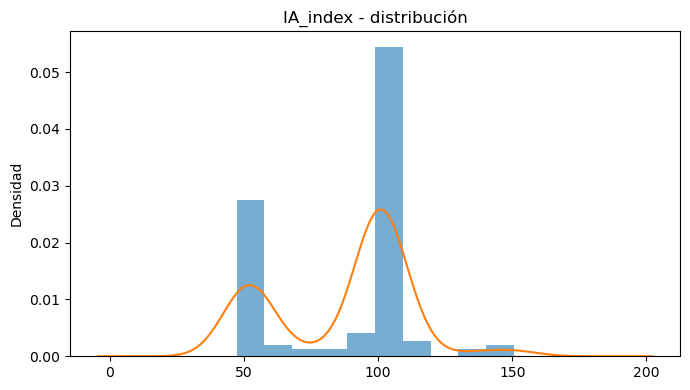

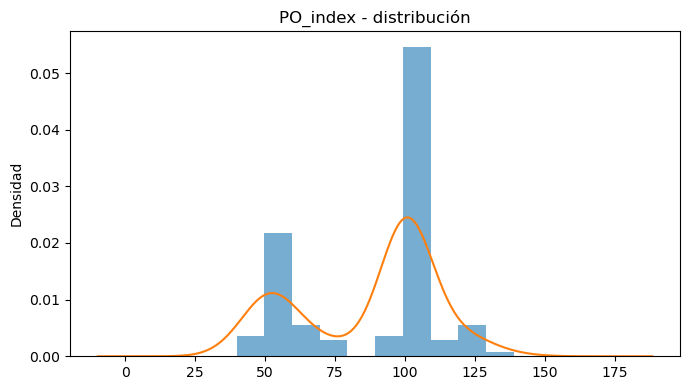

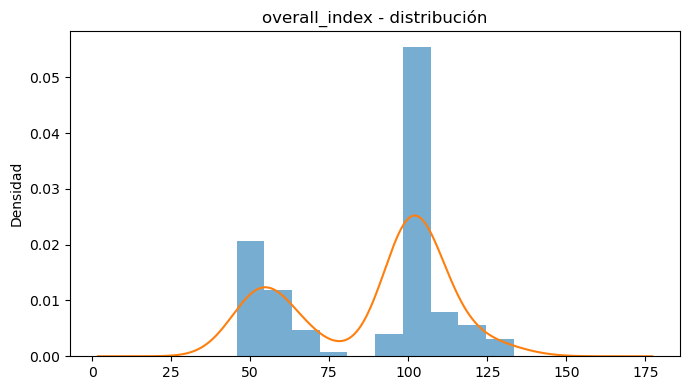

Distribución de tasas (inflación, cbrate, strate):


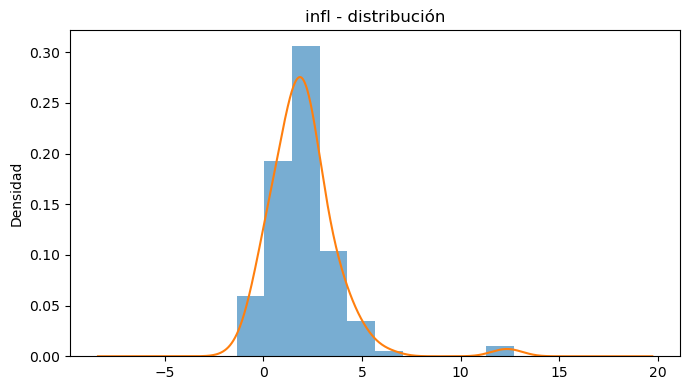

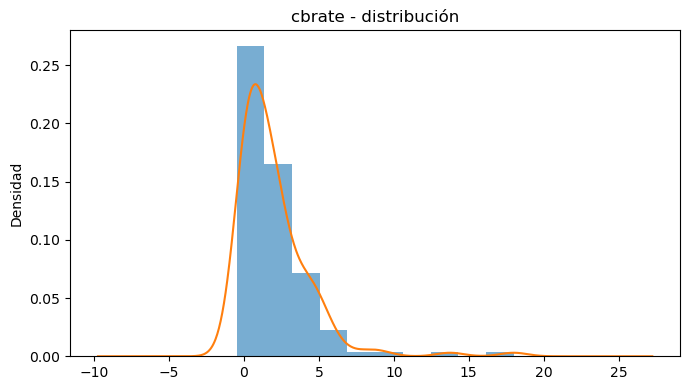

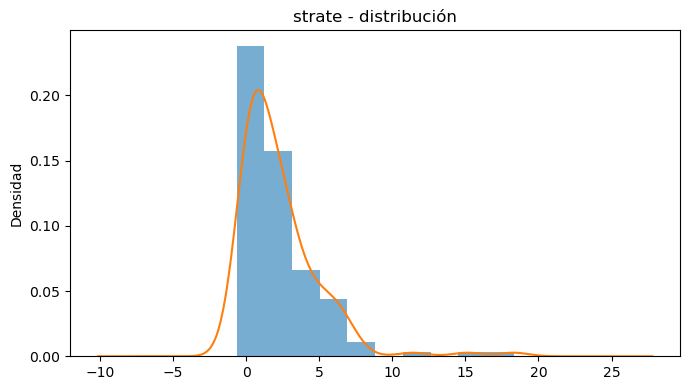

Distribución de agregados monetarios (M0–M4):


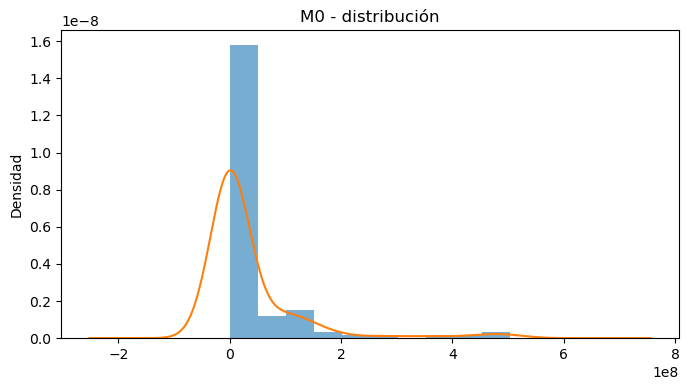

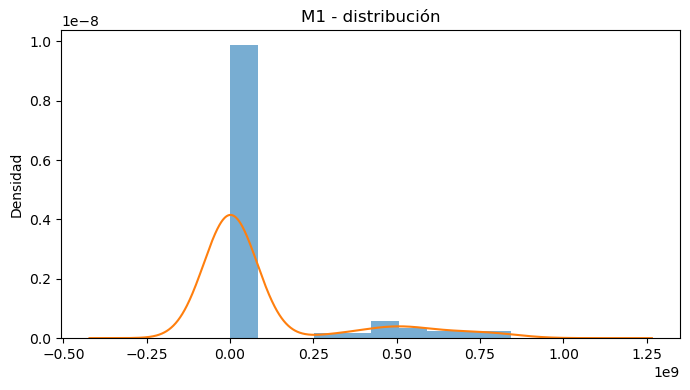

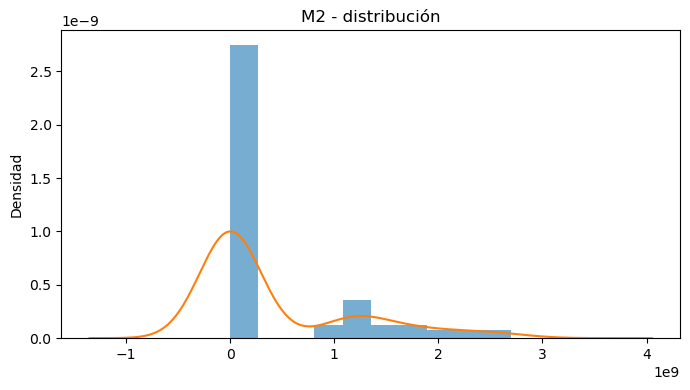

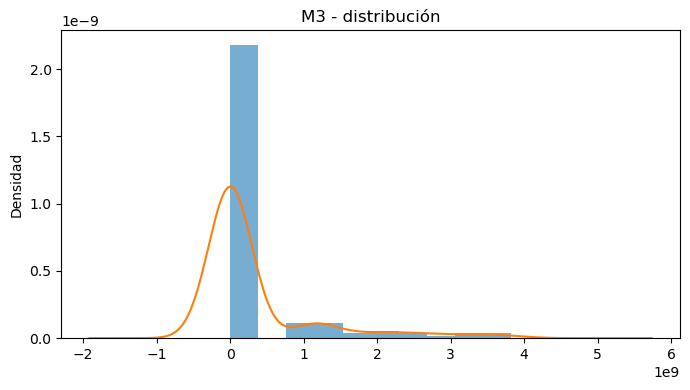

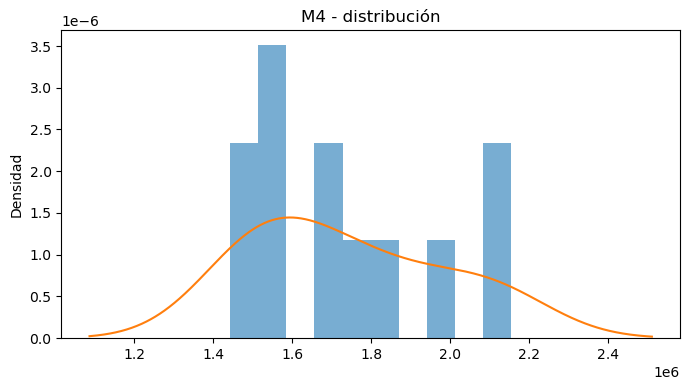

In [55]:
# Celda 10: Histogramas + KDE para índices, tasas e agregados monetarios

def plot_hist_kde(series, titulo):
    serie = series.dropna()
    if len(serie) == 0:
        print(f"Sin datos para {titulo}")
        return
    
    plt.figure(figsize=(7, 4))
    plt.hist(serie, bins=10, density=True, alpha=0.6)
    serie.plot(kind="kde")
    plt.title(titulo)
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()

indices = ["C_index", "IA_index", "PO_index", "overall_index"]
tasas = ["infl", "cbrate", "strate"]
agregados = ["M0", "M1", "M2", "M3", "M4"]

print("Distribución de índices de política monetaria:")
for v in indices:
    if v in base_panel.columns:
        plot_hist_kde(base_panel[v], f"{v} - distribución")

print("Distribución de tasas (inflación, cbrate, strate):")
for v in tasas:
    if v in base_panel.columns:
        plot_hist_kde(base_panel[v], f"{v} - distribución")

print("Distribución de agregados monetarios (M0–M4):")
for v in agregados:
    if v in base_panel.columns:
        plot_hist_kde(base_panel[v], f"{v} - distribución")

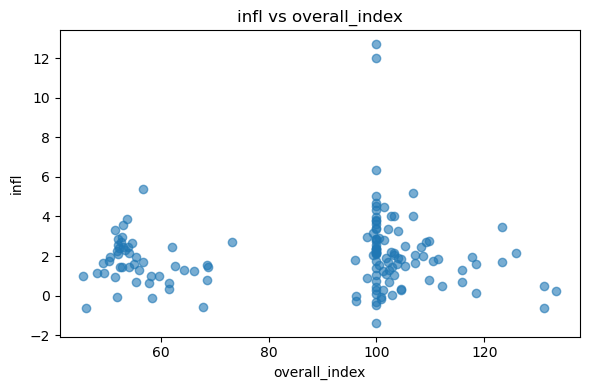

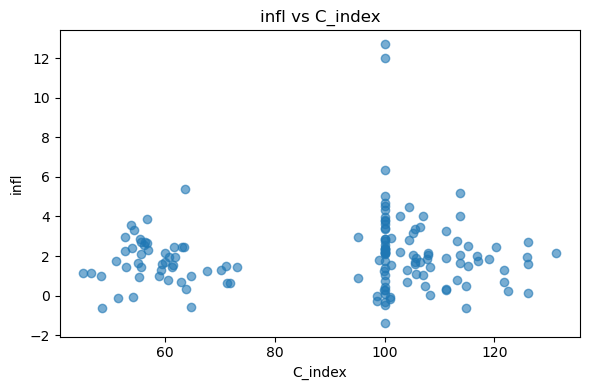

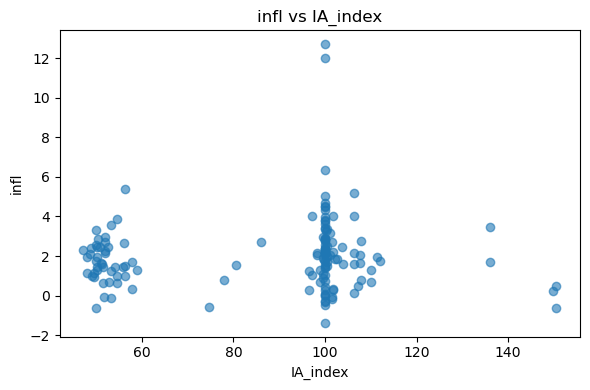

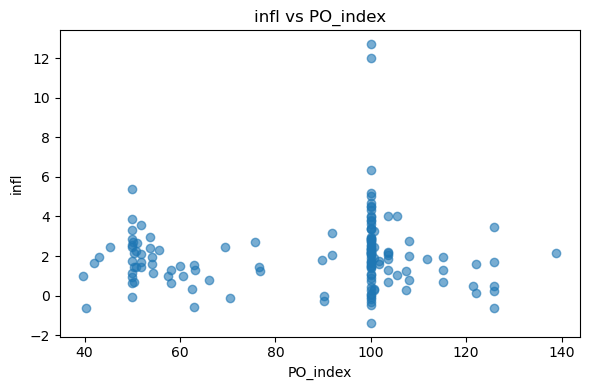

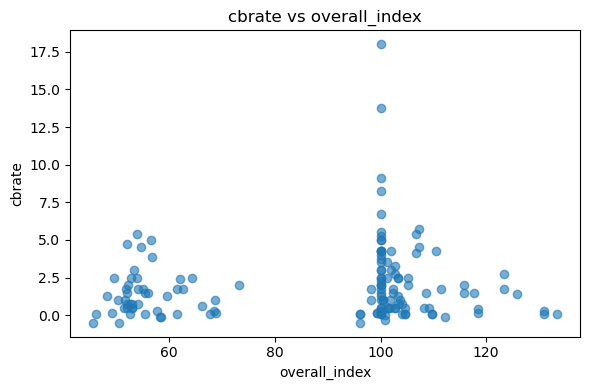

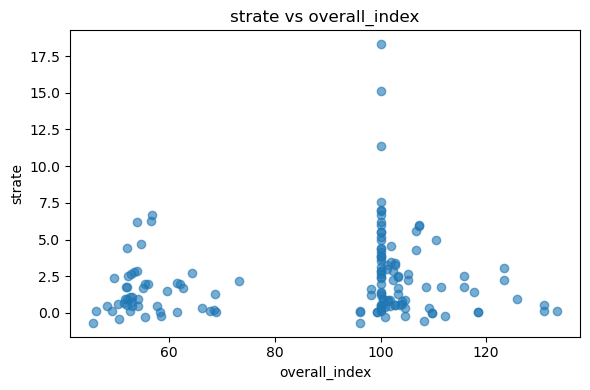

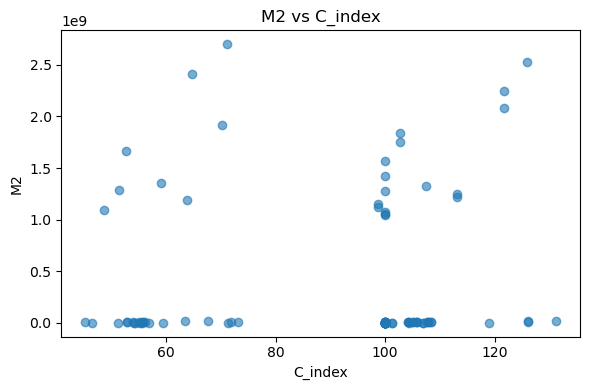

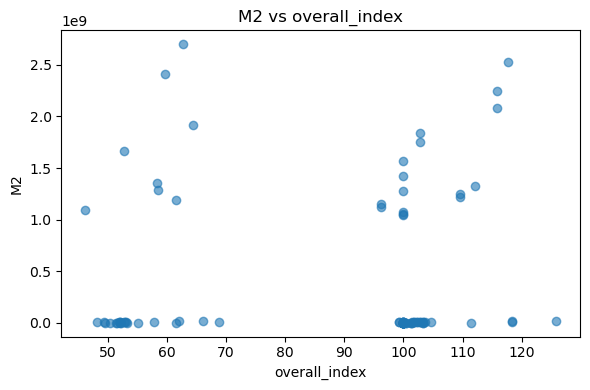

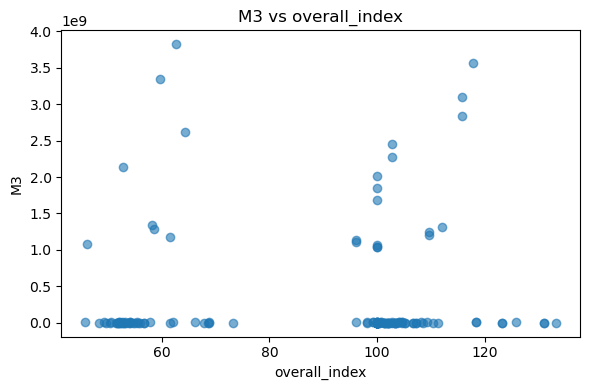

In [56]:
# Celda 11: Scatter plots de índices de política monetaria vs inflación, tasas y agregados

pairs = [
    ("overall_index", "infl"),
    ("C_index", "infl"),
    ("IA_index", "infl"),
    ("PO_index", "infl"),
    ("overall_index", "cbrate"),
    ("overall_index", "strate"),
    ("C_index", "M2"),
    ("overall_index", "M2"),
    ("overall_index", "M3")
]

for x, y in pairs:
    if x in base_panel.columns and y in base_panel.columns:
        plt.figure(figsize=(6, 4))
        plt.scatter(base_panel[x], base_panel[y], alpha=0.6)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"{y} vs {x}")
        plt.tight_layout()
        plt.show()

In [57]:
# Celda 12: Logistic regression - modelo completo para BankingCrisis

if "BankingCrisis" in base_panel.columns:
    cls_vars_full = [
        "C_index", "IA_index", "PO_index", "overall_index",
        "cbrate", "strate", "infl"
    ]
    cls_vars_full = [v for v in cls_vars_full if v in base_panel.columns]
    
    cls_df_full = base_panel[cls_vars_full + ["BankingCrisis"]].dropna().copy()
    
    print("Valores únicos de BankingCrisis:", cls_df_full["BankingCrisis"].unique())
    
    if cls_df_full["BankingCrisis"].nunique() == 2:
        X_cls_full = cls_df_full[cls_vars_full].values
        y_cls_full = cls_df_full["BankingCrisis"].values
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_cls_full, y_cls_full, test_size=0.3,
            random_state=123, stratify=y_cls_full
        )
        
        logit_full = LogisticRegression(max_iter=1000)
        logit_full.fit(X_train, y_train)
        
        y_pred_proba = logit_full.predict_proba(X_test)[:, 1]
        auc_full = roc_auc_score(y_test, y_pred_proba)
        
        print("\nAUC (ROC) para predicción de BankingCrisis:", round(auc_full, 3))
        
        coef_full = pd.Series(logit_full.coef_[0], index=cls_vars_full)
        print("\nCoeficientes del logit (impacto sobre la probabilidad de crisis):")
        display(coef_full)
    else:
        print("BankingCrisis no tiene dos categorías distintas en esta muestra.")
else:
    print("No está la variable BankingCrisis en base_panel.")

Valores únicos de BankingCrisis: [0. 1.]

AUC (ROC) para predicción de BankingCrisis: 0.788

Coeficientes del logit (impacto sobre la probabilidad de crisis):


C_index         -0.011103
IA_index         0.018441
PO_index         0.090375
overall_index   -0.073823
cbrate          -1.234425
strate           1.176184
infl             0.569867
dtype: float64

In [58]:
# Celda 13: Logistic regression simplificado para BankingCrisis
# (overall_index + infl + tasas) para reducir colinealidad

if "BankingCrisis" in base_panel.columns:
    cls_vars_simple = [
        "overall_index",
        "cbrate", "strate", "infl"
    ]
    cls_vars_simple = [v for v in cls_vars_simple if v in base_panel.columns]
    
    cls_df_simple = base_panel[cls_vars_simple + ["BankingCrisis"]].dropna().copy()
    
    print("Valores únicos de BankingCrisis (modelo simple):", cls_df_simple["BankingCrisis"].unique())
    
    if cls_df_simple["BankingCrisis"].nunique() == 2:
        X_cls_s = cls_df_simple[cls_vars_simple].values
        y_cls_s = cls_df_simple["BankingCrisis"].values
        
        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
            X_cls_s, y_cls_s, test_size=0.3,
            random_state=123, stratify=y_cls_s
        )
        
        logit_simple = LogisticRegression(max_iter=1000)
        logit_simple.fit(X_train_s, y_train_s)
        
        y_pred_proba_s = logit_simple.predict_proba(X_test_s)[:, 1]
        auc_s = roc_auc_score(y_test_s, y_pred_proba_s)
        
        print("\nAUC (ROC) modelo simple - BankingCrisis:", round(auc_s, 3))
        
        coef_simple = pd.Series(logit_simple.coef_[0], index=cls_vars_simple)
        print("\nCoeficientes del logit simple:")
        display(coef_simple)
    else:
        print("BankingCrisis no tiene dos categorías distintas en esta muestra.")
else:
    print("No está la variable BankingCrisis en base_panel.")

Valores únicos de BankingCrisis (modelo simple): [0. 1.]

AUC (ROC) modelo simple - BankingCrisis: 0.738

Coeficientes del logit simple:


overall_index    0.028787
cbrate          -1.245022
strate           1.198534
infl             0.553564
dtype: float64

Valores únicos de BankingCrisis (árbol): [0. 1.]

AUC (ROC) Árbol - BankingCrisis: 0.5

Importancia de variables (Árbol - BankingCrisis):


infl             0.742021
strate           0.257979
C_index          0.000000
PO_index         0.000000
IA_index         0.000000
cbrate           0.000000
overall_index    0.000000
dtype: float64

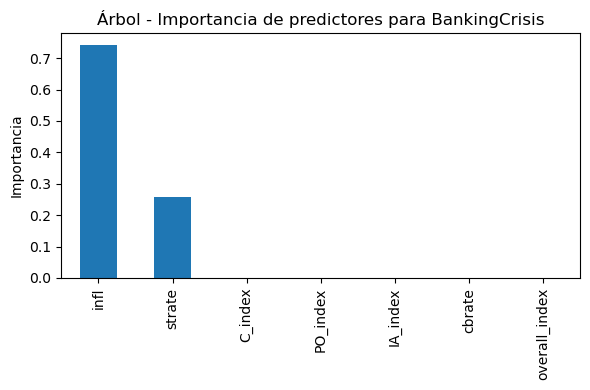

In [59]:
# Celda 14: Decision Tree Classifier para BankingCrisis

if "BankingCrisis" in base_panel.columns:
    tree_vars = [
        "C_index", "IA_index", "PO_index", "overall_index",
        "cbrate", "strate", "infl"
    ]
    tree_vars = [v for v in tree_vars if v in base_panel.columns]
    
    tree_df = base_panel[tree_vars + ["BankingCrisis"]].dropna().copy()
    
    print("Valores únicos de BankingCrisis (árbol):", tree_df["BankingCrisis"].unique())
    
    if tree_df["BankingCrisis"].nunique() == 2:
        X_tree = tree_df[tree_vars].values
        y_tree = tree_df["BankingCrisis"].values
        
        X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
            X_tree, y_tree, test_size=0.3,
            random_state=123, stratify=y_tree
        )
        
        tree_clf = DecisionTreeClassifier(
            max_depth=3,
            random_state=123
        )
        
        tree_clf.fit(X_train_t, y_train_t)
        
        y_proba_t = tree_clf.predict_proba(X_test_t)[:, 1]
        auc_t = roc_auc_score(y_test_t, y_proba_t)
        
        print("\nAUC (ROC) Árbol - BankingCrisis:", round(auc_t, 3))
        
        # Importancia de variables
        imp_tree = pd.Series(tree_clf.feature_importances_, index=tree_vars).sort_values(ascending=False)
        print("\nImportancia de variables (Árbol - BankingCrisis):")
        display(imp_tree)
        
        plt.figure(figsize=(6, 4))
        imp_tree.plot(kind="bar")
        plt.ylabel("Importancia")
        plt.title("Árbol - Importancia de predictores para BankingCrisis")
        plt.tight_layout()
        plt.show()
    else:
        print("BankingCrisis no tiene dos categorías distintas en esta muestra.")
else:
    print("No está la variable BankingCrisis en base_panel.")

Valores únicos de BankingCrisis (RF): [0. 1.]

AUC (ROC) Random Forest - BankingCrisis: 0.744

Importancia de variables (Random Forest - BankingCrisis):


infl             0.340955
cbrate           0.275049
strate           0.266978
C_index          0.043602
overall_index    0.035424
IA_index         0.023759
PO_index         0.014233
dtype: float64

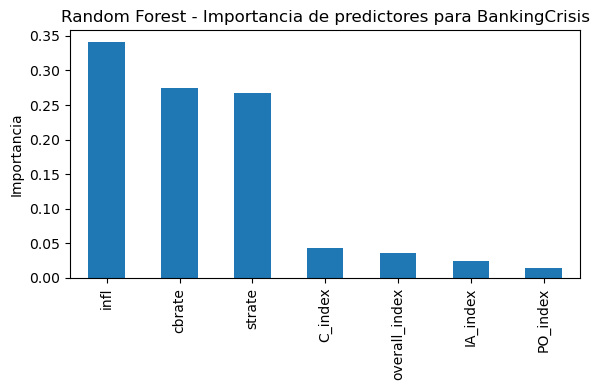

In [60]:
# Celda 15: Random Forest Classifier para BankingCrisis

if "BankingCrisis" in base_panel.columns:
    rf_vars = [
        "C_index", "IA_index", "PO_index", "overall_index",
        "cbrate", "strate", "infl"
    ]
    rf_vars = [v for v in rf_vars if v in base_panel.columns]
    
    rf_df = base_panel[rf_vars + ["BankingCrisis"]].dropna().copy()
    
    print("Valores únicos de BankingCrisis (RF):", rf_df["BankingCrisis"].unique())
    
    if rf_df["BankingCrisis"].nunique() == 2:
        X_rf = rf_df[rf_vars].values
        y_rf = rf_df["BankingCrisis"].values
        
        X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
            X_rf, y_rf, test_size=0.3,
            random_state=123, stratify=y_rf
        )
        
        rf_clf = RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            random_state=123,
            n_jobs=-1
        )
        
        rf_clf.fit(X_train_rf, y_train_rf)
        
        y_proba_rf = rf_clf.predict_proba(X_test_rf)[:, 1]
        auc_rf = roc_auc_score(y_test_rf, y_proba_rf)
        
        print("\nAUC (ROC) Random Forest - BankingCrisis:", round(auc_rf, 3))
        
        imp_rf = pd.Series(rf_clf.feature_importances_, index=rf_vars).sort_values(ascending=False)
        print("\nImportancia de variables (Random Forest - BankingCrisis):")
        display(imp_rf)
        
        plt.figure(figsize=(6, 4))
        imp_rf.plot(kind="bar")
        plt.ylabel("Importancia")
        plt.title("Random Forest - Importancia de predictores para BankingCrisis")
        plt.tight_layout()
        plt.show()
    else:
        print("BankingCrisis no tiene dos categorías distintas en esta muestra.")
else:
    print("No está la variable BankingCrisis en base_panel.")

In [61]:
# Celda 16: MCO - Inflation Rate ~ índices de política + tasas + agregados monetarios

y_var = "infl"

x_vars = [
    "C_index", "IA_index", "PO_index", "overall_index",
    "cbrate", "strate",
    "M1", "M2", "M3",
    "rGDP_pc", "cgovdebt_GDP", "cgovdef_GDP"
]

x_vars = [v for v in x_vars if v in base_panel.columns]

print("Variable dependiente:", y_var)
print("Variables explicativas:", x_vars)

reg_df = base_panel[[y_var] + x_vars].dropna().copy()

print("\nDimensiones reg_df:", reg_df.shape)
display(reg_df.head())

X_reg = reg_df[x_vars].values
y_reg = reg_df[y_var].values

X_reg_ols = sm.add_constant(X_reg)
ols_infl = sm.OLS(y_reg, X_reg_ols).fit()

print(ols_infl.summary())

Variable dependiente: infl
Variables explicativas: ['C_index', 'IA_index', 'PO_index', 'overall_index', 'cbrate', 'strate', 'M1', 'M2', 'M3', 'rGDP_pc', 'cgovdebt_GDP', 'cgovdef_GDP']

Dimensiones reg_df: (85, 13)


,infl,C_index,IA_index,PO_index,overall_index,cbrate,strate,M1,M2,M3,rGDP_pc,cgovdebt_GDP,cgovdef_GDP
0,2.356021,100.000000,100.000000,100.0,100.000000,6.75,6.667500,350000.00000,1091230.000,984000.0,64242.105469,6.077793,1.567831
1,4.347826,100.000000,100.000000,100.0,100.000000,4.25,6.973333,396200.00000,1246290.000,1143400.0,64509.472656,7.638950,1.816923
2,1.770152,100.000000,100.000000,100.0,100.000000,3.75,3.147518,412400.00000,1252240.000,1189400.0,64451.996094,11.620013,-2.433685
3,2.863259,55.601204,50.499058,50.0,52.073537,4.75,4.441250,445500.00000,1369640.000,1312000.0,65049.140625,14.354592,-3.842337
12,2.130584,100.000000,100.000000,100.0,100.000000,4.25,4.151667,392984.59375,1069179.625,1123508.0,53845.664062,29.826223,0.933217


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     6.153
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           2.63e-07
Time:                        16:42:03   Log-Likelihood:                -111.84
No. Observations:                  85   AIC:                             249.7
Df Residuals:                      72   BIC:                             281.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9748      0.566      3.489      0.0

In [62]:
# Celda 17: LASSO con CV para seleccionar variables relevantes para inflación

lasso_cv = LassoCV(cv=5, n_alphas=100, random_state=123)
lasso_cv.fit(X_reg, y_reg)

print(f"Alpha óptimo (LASSO): {lasso_cv.alpha_:.6f}")
print("R² (train) con LASSO:", round(lasso_cv.score(X_reg, y_reg), 3))

coef_lasso = pd.Series(lasso_cv.coef_, index=x_vars)
print("\nCoeficientes LASSO (coef ≠ 0 → variables más relevantes):")
display(coef_lasso)

Alpha óptimo (LASSO): 12053399.560462
R² (train) con LASSO: 0.209

Coeficientes LASSO (coef ≠ 0 → variables más relevantes):


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07836494457419008, tolerance: 0.012663744306999477
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09164008309704741, tolerance: 0.012663744306999477
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09987594305789571, tolerance: 0.012663744306999477
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_des

C_index          0.000000e+00
IA_index         0.000000e+00
PO_index         0.000000e+00
overall_index    0.000000e+00
cbrate           0.000000e+00
strate           0.000000e+00
M1              -3.649009e-09
M2               0.000000e+00
M3               6.578911e-10
rGDP_pc          0.000000e+00
cgovdebt_GDP    -0.000000e+00
cgovdef_GDP      0.000000e+00
dtype: float64

Variable dependiente (RF regresión): infl
Variables explicativas: ['C_index', 'IA_index', 'PO_index', 'overall_index', 'cbrate', 'strate', 'M1', 'M2', 'M3', 'rGDP_pc', 'cgovdebt_GDP', 'cgovdef_GDP']

Dimensiones rf_reg_df: (85, 13)
R² (train) RF inflación: 0.905
R² (test)  RF inflación: 0.207

Importancia de variables (Random Forest - inflación):


strate           0.397684
cbrate           0.187074
cgovdebt_GDP     0.116369
cgovdef_GDP      0.080300
M1               0.045994
rGDP_pc          0.041091
C_index          0.025845
IA_index         0.023600
M2               0.023041
overall_index    0.022388
M3               0.020315
PO_index         0.016299
dtype: float64

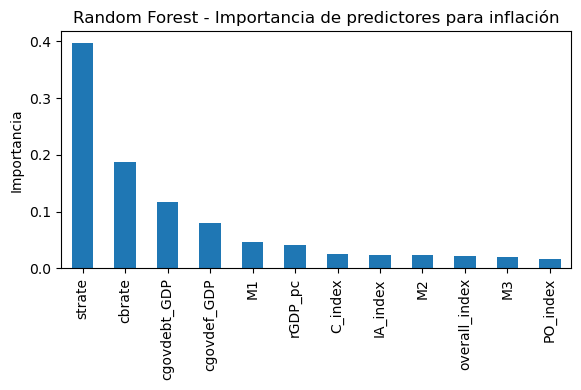

In [63]:
# Celda 18: Random Forest Regressor para inflación

rf_reg_vars = [
    "C_index", "IA_index", "PO_index", "overall_index",
    "cbrate", "strate",
    "M1", "M2", "M3",
    "rGDP_pc", "cgovdebt_GDP", "cgovdef_GDP"
]

rf_reg_vars = [v for v in rf_reg_vars if v in base_panel.columns]

print("Variable dependiente (RF regresión): infl")
print("Variables explicativas:", rf_reg_vars)

rf_reg_df = base_panel[["infl"] + rf_reg_vars].dropna().copy()

print("\nDimensiones rf_reg_df:", rf_reg_df.shape)

X_rf_reg = rf_reg_df[rf_reg_vars].values
y_rf_reg = rf_reg_df["infl"].values

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_rf_reg, y_rf_reg, test_size=0.3, random_state=123
)

rf_reg = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=123,
    n_jobs=-1
)

rf_reg.fit(X_train_r, y_train_r)

r2_train = rf_reg.score(X_train_r, y_train_r)
r2_test = rf_reg.score(X_test_r, y_test_r)

print(f"R² (train) RF inflación: {r2_train:.3f}")
print(f"R² (test)  RF inflación: {r2_test:.3f}")

imp_rf_reg = pd.Series(rf_reg.feature_importances_, index=rf_reg_vars).sort_values(ascending=False)
print("\nImportancia de variables (Random Forest - inflación):")
display(imp_rf_reg)

plt.figure(figsize=(6, 4))
imp_rf_reg.plot(kind="bar")
plt.ylabel("Importancia")
plt.title("Random Forest - Importancia de predictores para inflación")
plt.tight_layout()
plt.show()